In [80]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [81]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from datetime import timedelta
from time import gmtime, strftime

## Reflect Tables into SQLALchemy ORM

In [82]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [83]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [84]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

# reflect the tables
inspector = inspect(engine)
inspector.get_table_names()

# View all of the classes that automap found


['measurement', 'station']

In [85]:
# Save references to each table

Station= Base.classes.station
Measurement= Base.classes.measurement

In [86]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [87]:
# Display the row's columns and data in dictionary format
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fa32ace4160>,
 'station': 'USC00519397',
 'longitude': -157.8168,
 'elevation': 3.0,
 'name': 'WAIKIKI 717.2, HI US',
 'latitude': 21.2716,
 'id': 1}

In [88]:
# Display the row's columns and data in dictionary format
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fa32ace45e0>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1}

## Bonus Challenge Assignment: Temperature Analysis II

In [89]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [90]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
temp_of_2012 = calc_temps('2012-01-01', '2012-12-31')[0]
print(temp_of_2012)

(56.0, 72.26401515151515, 86.0)


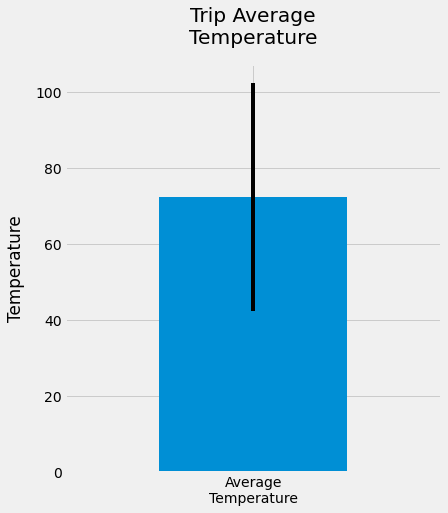

In [91]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.figure(num=None, figsize=(6,7), dpi=None,                   
           facecolor=None, edgecolor=None, frameon=True)
# Fot x axis
x_axis = 'Average\nTemperature'                                 
# Fot y axis
y_axis = temp_of_2012[1]                                        
# To plot bar chart 
plt.bar(x_axis, y_axis, label='Average temperatures',           
        width=.5, yerr=(temp_of_2012[0]-temp_of_2012[2]))       

plt.xlim(-.5, .5)                                               

plt.title("Trip Average\nTemperature", fontsize='x-large',      
           loc='center', pad=20)

plt.ylabel("Temperature",                         
           fontsize='large', labelpad=10)

plt.savefig("output_figures/average_trip_temperature.png",    
            transparent=False)
plt.show()



### Daily Rainfall Average

In [92]:
# Calculate the total amount of rainfall per weather station for your 
# trip dates using the previous year's matching dates.

# Setting trip dates
start_date_trip= '2012-01-01'
end_date_trip= '2012-01-20'

# Sort this in descending order by precipitation amount and list 
# the station, name, latitude, longitude, and elevation

# Query Joining tables and ordering in descending order
calc_weather = session.query(Station.id, Station.station, Station.latitude,\
            Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
            filter(Measurement.station== Station.station).\
            filter(Measurement.date>=start_date_trip, Measurement.date<=end_date_trip).\
            group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).statement

# Create the dataframe and clean up column names
pcrp_per_station = pd.read_sql_query(calc_weather, session.bind).\
    rename(columns={'id' : 'Station ID', 'station' : 'Station Name', 
                    'latitude' : 'Latitude', 'longitude' : 'Longitude', 
                    'elevation' : 'Elevation', 'sum_1': 'Total_Rainfall'})
pcrp_per_station

,Station ID,Station Name,Latitude,Longitude,Elevation,Total_Rainfall
0,5,USC00518838,21.49920,-158.01110,306.6,1.73
1,7,USC00519281,21.45167,-157.84889,32.9,0.91
2,9,USC00516128,21.33310,-157.80250,152.4,0.77
3,3,USC00514830,21.52130,-157.83740,7.0,0.59
4,2,USC00513117,21.42340,-157.80150,14.6,0.43
5,6,USC00519523,21.33556,-157.71139,19.5,0.28
6,1,USC00519397,21.27160,-157.81680,3.0,0.06
7,8,USC00511918,21.31520,-157.99920,0.9,0.02
8,4,USC00517948,21.39340,-157.97510,11.9,0.00


In [93]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [105]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date_trip= '2012-01-01'
end_date_trip= '2012-01-20'

# Use the start and end date to create a range of dates
start_date_trip_range = dt.strptime(start_date_trip, '%Y-%m-%d')
end_date_trip_range = dt.strptime(end_date_trip, '%Y-%m-%d')

trip_range= end_date_trip_range-start_date_trip_range
# Strip off the year and save a list of strings in the format %m-%d
trip_range

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.

# Creating list Normals
normals= [['DATE', 'MIN TEMP', 'AVEG TEMP', 'MIN TEMP']]

# Append to list with a loop
for x in range(trip_range.days+1):
    date_for_trip= (start_date_trip_range + timedelta(days=x)).strftime('%m-%d')
    #trip_date= (start_date_trip_range+ timedelta(days=day))
       

TypeError: 'datetime.timedelta' object is not callable

In [102]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

In [ ]:
# Plot the daily normals as an area plot with `stacked=False`

## Close Session